In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.integrate import odeint
from numpy import linalg as LA
from numpy.linalg import inv
from math import exp
from math import expm1
from scipy import linalg

In [2]:
def get_yeastract_data(yeastract_csv_filename, gene_to_orf_filename="tftoorf.csv", as_orf=False):
    '''
    Returns Yeastract network data as a pandas DataFrame.
    '''
    def tf_to_gene(tf_name):
        '''
        Removes trailing "p" from transcription factor name and turn into uppercase.
        '''
        if tf_name[-1] == 'p':
            return tf_name.upper()[:-1]
        else:
            return tf_name
    
    yeastract_data = pd.read_csv(yeastract_csv_filename, sep= ";")
    gene_to_orf_df = pd.read_csv(gene_to_orf_filename)
    
    tf_list = list(yeastract_data['6855'])
    gene_list = list(yeastract_data.columns.values)[1:]
    
    # Fix dataframe so it has right things as rownames.
    yeastract_data = yeastract_data.rename(index=yeastract_data['6855'])
    yeastract_data = yeastract_data.iloc[:, 1:]
    
    tf_list = [tf_to_gene(tf) for tf in tf_list]
    if as_orf:
        gene_to_orf = dict(zip(list(gene_to_orf_df.iloc[:,0]), list(gene_to_orf_df.iloc[:,2])))
        
        rownames = [gene_to_orf[tf] for tf in tf_list]
        # Change to TF if possible, otherwise keep same name.
        colnames = [gene_to_orf.get(gene, gene) for gene in gene_list]
    else:
        rownames = tf_list
        colnames = gene_list
    
    final_data = pd.DataFrame(np.array(yeastract_data), index=rownames, columns=colnames)
    
    return final_data

def get_gasch_data(gasch_data_filename="complete_dataset_gasch.txt", 
                   orf_to_gene_filename="orfname_time_course_fixed.csv",
                   supset=None ,
                   as_orf=False):
    '''
    Returns heat shock time-course data from Gasch as DataFrame.
    '''
    gasch_data = pd.read_csv(gasch_data_filename, sep="\t")
#    gasch_data = gasch_data.iloc[:,:11] # Filter only heat-shock data from first experiment (hs-1).
    
    if not as_orf:
        # Rename as genes.
        orf_to_gene_df = pd.read_csv(orf_to_gene_filename)
        orfs = list(orf_to_gene_df.iloc[:,0])
        genes = list(orf_to_gene_df.iloc[:,3])
        
        # Remove unknowns, keep original name.
        genes = [gene if gene != 'Unknown' else orfs[i] for i, gene in enumerate(genes)]
        orf_to_gene = dict(zip(orfs, genes))
        
        orf_list = list(gasch_data["UID"])
        gene_names = [orf_to_gene.get(orf, orf) for orf in orf_list]
        #print(gene_names)
        gasch_data["UID"] = gene_names
        gasch_data = gasch_data.rename(index=gasch_data["UID"])
        gasch_data = gasch_data.iloc[:, 1:]
        if supset != None:
            to_delete = set(gene_names)-set(supset)
            to_delete_list = list(to_delete)
            gasch_data = gasch_data.drop(to_delete_list)
    return gasch_data
    

def squarify(df, sort=False):
    '''
    Turns Yeastract DataFrame into a square dataframe (i.e. adjacency matrix).
    '''
    cols=list(df.columns)
    rows=list(df.index)
    d = []
    for x in cols:
        if x in rows:
            d.append(list(df.loc[x]))
        else:
            d.append([0]*len(cols))
    A = np.array(d)
    return pd.DataFrame(A, index=cols, columns=cols)

def reorder(target_orf, adj_matrix):
    A = target_orf #input the list of target orf name
    B = adj_matrix #input the adj matrix

    #First we want to extract the header from the adj matrix and compare them with the list

    B_header = list(B)

    AB_diff = list(set(B_header) - set(A))
    #print(set(A)<set(B_header))
    A_total = A + AB_diff
    B = B[A_total]
    B = B.reindex(A_total)
    return B

In [5]:
yeastract_data_activation = get_yeastract_data("heat_shock_act.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("heat_shock_inh.csv","tftoorf.csv")

In [9]:
yeastract_data_activation

,PAU8,SEO1,YAL066W,YAL065C,YAL064W-B,TDA8,YAL064W,FLO9,YBR089W,NHP6b,...,YER145C-A,YER190C-B,YGL194C-A,YIL102C-A,YJL077W-A,YKL023C-A,YKL065W-A,YPR010C-A,YPR145C-A,tX(XXX)L
MAL63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OAF1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PDR3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HAP3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TOD6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SEF1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RTG3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EDS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
REB1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NRG2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
yeastract_data_activation.loc("MAL63asdf")

In [67]:
cols=list(yeastract_data_activation.columns)
nonzerocolsact=[]
for gene in cols:
    if sum(yeastract_data_activation[gene])>0:
        nonzerocolsact.append(gene)
cols=list(yeastract_data_inhibition.columns)
nonzerocolsinh=[]
for gene in cols:
    if sum(yeastract_data_inhibition[gene])>0:
        nonzerocolsinh.append(gene)
rows=list(yeastract_data_activation.index)
nonzerorowsact=[]
for tf in rows:
    if sum(yeastract_data_activation.loc[tf])>0:
        nonzerorowsact.append(tf)
rows=list(yeastract_data_inhibition.index)
nonzerorowsinh=[]
for tf in rows:
    if sum(yeastract_data_inhibition.loc[tf])>0:
        nonzerorowsinh.append(tf)

In [69]:
len(nonzerorowsact)

15

In [74]:
nonzerocolstot=list(set(nonzerocolsact).union(set(nonzerocolsinh)))
nonzerorowstot=list(set(nonzerorowsact).union(set(nonzerorowsinh)))
print(len(nonzerorowstot))
print(nonzerorowstot)
print(len(nonzerocolstot))
heat_shock_starters=["HSF1","MSN2","MSN4","RLM1","SWI4"]
nonzerorowsinh.index("SWI4")
tfsaffected=list(set(nonzerorowstot).intersection(set(nonzerocolstot)))
print(tfsaffected)

16
['MSN1', 'HSF1', 'SWI4', 'REB1', 'MSN4', 'FHL1', 'RLM1', 'MGA2', 'SPT23', 'GCN4', 'RAP1', 'ABF1', 'YAP1', 'HOT1', 'MSN2', 'MCM1']
721
['ABF1', 'SPT23', 'REB1']


In [84]:
print(nonzerorowsact)
print(nonzerorowsinh)

['GCN4', 'SWI4', 'HSF1', 'MGA2', 'SPT23', 'MSN4', 'ABF1', 'YAP1', 'MSN2', 'MCM1', 'HOT1', 'RAP1', 'MSN1', 'RLM1', 'FHL1']
['REB1', 'GCN4', 'SWI4', 'HSF1', 'MGA2', 'SPT23', 'MSN4', 'ABF1', 'YAP1', 'MSN2', 'HOT1', 'RAP1', 'MSN1', 'FHL1']


In [ ]:
genesaffbyint=[]
f

In [86]:
genesaffbyint=[]
for gene in nonzerocolstot:
    if yeastract_data_activation[gene]["ABF1"]>0 or yeastract_data_activation[gene]["SPT23"] > 0 or gene == "ABF1" or gene == "SPT23" or gene == "REB1":
        genesaffbyint.append(gene)

In [88]:
len(genesaffbyint)

51

In [ ]:
heatshock_sub_act = yeastract_data_activation[nonzerocolsact]
heatshock_sub_

In [82]:
yeastract_data_activation['ABF1']['MAL63','OAF1']

KeyError: ('MAL63', 'OAF1')

In [35]:
nonzerocolstot=list(set(nonzerocolsact).union(set(nonzerocolsinh)))
print(len(nonzerocolstot))
heat_shock_starters=["HSF1","MSN2","MSN4","RLM1","SWI4"]


nonzerocolstot.index("YGL073W")

721


ValueError: 'YGL073W' is not in list

In [48]:
yeastract_data_activation.iloc[1]

PAU8         0
SEO1         0
YAL066W      0
YAL065C      0
YAL064W-B    0
TDA8         0
YAL064W      0
FLO9         0
YBR089W      0
NHP6b        0
YBR090C      0
TIM12        0
PHO3         0
PHO5         0
PBY1         0
RXT2         0
YBR096W      0
VPS15        0
MMS4         0
YBR099C      0
FES1         0
EXO84        0
SIF2         0
YBR103C-A    0
YMC2         0
VID24        0
PHO88        0
IML3         0
AIM3         0
CMD1         0
            ..
YBL100W-A    0
YBL100W-B    0
YBL100W-C    0
ADF1         0
YDR524W-C    0
YLR157W-D    0
YLR157W-E    0
YNL097C-B    0
RTM1         0
MAL63        0
ICR1         0
PWR1         0
COX26        0
WIP1         0
MEO1         0
YBR201C-A    0
YCL048W-A    0
YDL007C-A    0
YDL022C-A    0
YDR461C-A    0
YER145C-A    0
YER190C-B    0
YGL194C-A    0
YIL102C-A    0
YJL077W-A    0
YKL023C-A    0
YKL065W-A    0
YPR010C-A    0
YPR145C-A    0
tX(XXX)L     0
Name: OAF1, Length: 6855, dtype: int64

In [3]:
yeastract_data_activation = get_yeastract_data("heat_shock_act.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("heat_shock_inh.csv","tftoorf.csv")
adj_mat_activation = squarify(yeastract_data_activation)
adj_mat_inhibition = squarify(yeastract_data_inhibition)
adj_matrix=adj_mat_activation-adj_mat_inhibition
cols = list(adj_mat_activation.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)
adj_matrix = reorder(list(gasch_data.index),adj_matrix)
gasch_esr = get_gasch_data("figure3_gasch_paper.cdt","orfname_time_course_fixed.csv",cols)

In [6]:
yeastract_data_activation = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("matrix_inhibitor.csv","tftoorf.csv")
adj_mat_activation = squarify(yeastract_data_activation)
adj_mat_inhibition = squarify(yeastract_data_inhibition)
adj_matrix=adj_mat_activation-adj_mat_inhibition
cols = list(adj_mat_activation.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)
adj_matrix = reorder(list(gasch_data.index),adj_matrix)
gasch_esr = get_gasch_data("figure3_gasch_paper.cdt","orfname_time_course_fixed.csv",cols)

In [14]:
yeastract_data_activationtest = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
colstest=list(yeastract_data_activationtest.columns)
nonzerocolstest=[]
for gene in colstest:
    if sum(yeastract_data_activationtest[gene])>0:
        nonzerocolstest.append(gene)

In [16]:
len(nonzerocolstest)

2927

In [49]:
esr_genes=list(gasch_esr.index)

In [50]:
gasch_data_cols=gasch_data.columns
gasch_data_cols[0:17]

Index(['NAME', 'GWEIGHT', 'Heat Shock 05 minutes hs-1',
       'Heat Shock 10 minutes hs-1', 'Heat Shock 15 minutes hs-1',
       'Heat Shock 20 minutes hs-1', 'Heat Shock 30 minutes hs-1',
       'Heat Shock 40 minutes hs-1', 'Heat Shock 60 minutes hs-1',
       'Heat Shock 80 minutes hs-1', 'Heat Shock 000 minutes hs-2',
       'Heat Shock 000 minutes  hs-2', 'Heat Shock 000 minutes  hs-2.1',
       'Heat Shock 005 minutes  hs-2', 'Heat Shock 015 minutes  hs-2',
       'Heat Shock 030inutes  hs-2', 'Heat Shock 060 minutes  hs-2'],
      dtype='object')

In [28]:
#These transcription factors are the ones we expect to turn on the heat shock response.
heat_shock_starters=["HSF1","MSN2","MSN4","RLM1","SWI4"]

In [7]:
def num_to_rgb(num,maxi):
    if num > 0:
        return [int(255*num/maxi), 0, 0]
    elif num < 0:
        return [0,int(-255*num/maxi),0]
    elif num ==0:
        return [0,0,0]
    else:
        return [0,0,255]
def make_plot(rawdata,filename,maxi=8,pixperpoint=10):
    numrows=len(rawdata)
    numcols=len(rawdata[0])
    raw_pixel_data = np.zeros([numrows,pixperpoint*numcols,3],dtype=np.uint8)
    for i in range(numrows):
        for j in range(numcols):
            for k in range(pixperpoint):
                raw_pixel_data[i,pixperpoint*j+k] = num_to_rgb(rawdata[i,j], maxi)
    img = Image.fromarray(raw_pixel_data, 'RGB')
    img.save(filename)

In [53]:
esr_raw_data=gasch_data.loc[esr_genes]
esr_raw_data_heat_shock=esr_raw_data[gasch_data_cols[2:10]]
esr_raw_data_heat_shock_array=np.array(esr_raw_data_heat_shock)
make_plot(esr_raw_data_heat_shock_array,'esr_heat_shock.png',8,10)

In [54]:
for h in heat_shock_starters:
    print(h,cols.index(h))

HSF1 1807
MSN2 4038
MSN4 3154
RLM1 5525
SWI4 1405


In [8]:
A=np.transpose(np.array(adj_matrix))
u=np.zeros(len(cols))
u[1807] = 1
u[4038] = 1
u[3154] = 1
u[5525] = 1
u[1405] = 1
y0=np.zeros(len(cols))
kf=0.5

In [ ]:
%%time
linalg.expm(A)

In [168]:
def get_exact_soln(A,y0,kf,u,timesteps,zeroics=True,zeroforcing=False):
    if zeroforcing and zeroics:
        print("You need to input something!")
        return 0
    eigvals,eigvects = LA.eig(A-kf*np.identity(len(A)))
    V=eigvects
    Vinv = inv(V)
    if not zeroforcing:
        Vhat1= Vinv@u
    if not zeroics:
        Vhat2=Vinv@y0
    if not zeroforcing:
        mdf=[]
        mdtemp=[]
        for t in timesteps:
            for lamda in eigvals:
                if np.abs(lamda)<0.00000001:
                    mdtemp.append(t)
                else:
                    mdtemp.append((expm1(lamda*t))/lamda)
            mdf.append(mdtemp)
            mdtemp=[]
    if not zeroics:
        mdi=[]
        mdtemp=[]
        for t in timesteps:
            for lamda in eigvals:
                mdtemp.append(exp(lamda*t))
            mdi.append(mdtemp)
            mdtemp=[]
    time_course_force=np.zeros((len(timesteps),len(A)))
    time_course_ics=np.zeros((len(timesteps),len(A)))
    if not zeroics:
        for tstep in range(len(timesteps)):
            time_course_ics[tstep] = V @ np.diag(mdi[tstep])@Vhat2
    if not zeroforcing:
        for tstep in range(len(timesteps)):
            time_course_force[tstep] = V @ np.diag(mdf[tstep])@Vhat1
    time_course = time_course_force + time_course_ics
    time_course=np.transpose(time_course)
    time_course=time_course.real
    return time_course

In [158]:
eigvals,eigvects = LA.eig(A)

In [166]:
sumcols=np.sum(eigvects.real,axis=0)
len(np.where(np.abs(sumcols)<0.00001)[0])

7

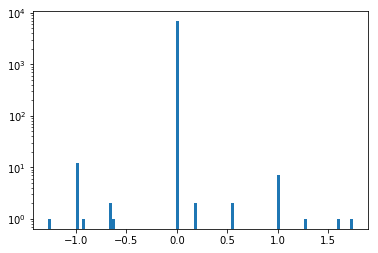

In [160]:
plt.hist(np.real(eigvals),bins=100,log=True)
plt.show()

In [157]:
time_course = get_exact_soln(A,np.zeros(len(A)),0,u,[0, 5, 10, 15, 20, 30, 40, 60, 80])

LinAlgError: Singular matrix

In [186]:
print(sum(adj_mat_activation["PAU8"]))
print(sum(adj_mat_activation["SEO1"]))
print(sum(adj_mat_activation["YAL066W"]))
print(sum(adj_mat_activation["YAL065C"]))
print(sum(adj_mat_activation["YAL064W-B"]))
print(sum(adj_mat_activation["TDA8"]))
print(sum(adj_mat_activation["YAL064W"]))
print(sum(adj_mat_activation["FLO9"]))
print(sum(adj_mat_activation["YBR089W"]))

1
1
0
0
0
1
4
3
0


In [182]:
adj_mat_activation

,PAU8,SEO1,YAL066W,YAL065C,YAL064W-B,TDA8,YAL064W,FLO9,YBR089W,NHP6b,...,YER145C-A,YER190C-B,YGL194C-A,YIL102C-A,YJL077W-A,YKL023C-A,YKL065W-A,YPR010C-A,YPR145C-A,tX(XXX)L
PAU8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SEO1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL066W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL065C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL064W-B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TDA8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL064W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FLO9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YBR089W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NHP6b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
act_trans=adj_mat_activation.transpose()
act_trans.to_csv('activation.csv',header=False,index=False)

In [178]:
inh_trans=adj_mat_inhibition.transpose()
inh_trans.to_csv('inhibition.csv',header=False,index=False)

In [99]:
def f(y, t0, A, u, kf):
    return (A - kf * np.identity(len(A))) @ y + u

In [169]:
id2=np.array([[1,3.5],[1,1]])
u=[1,0]
tsteps=[0,1,2,3]
yinit=[1,5]
y = odeint(f, y0=yinit,t=tsteps,args=(id2, u, 0))
print(np.transpose(y))
y_analytic=get_exact_soln(id2,yinit,0,u,tsteps,False,False)
print(y_analytic)
print(y_analytic-np.transpose(y))

[[  1.00000000e+00   9.28692306e+01   1.66690825e+03   2.94313525e+04]
 [  5.00000000e+00   5.11530951e+01   8.91276171e+02   1.57314784e+04]]
[[  1.00000000e+00   9.28692276e+01   1.66690811e+03   2.94313487e+04]
 [  5.00000000e+00   5.11530935e+01   8.91276098e+02   1.57314764e+04]]
[[ -8.88178420e-16  -2.99849127e-06  -1.35000356e-04  -3.83154001e-03]
 [  0.00000000e+00  -1.60332806e-06  -7.21609690e-05  -2.04804439e-03]]


In [134]:
testmat=np.array([[1,0],[0,2]])
testmat[1]=[4,1]
print(testmat)

[[1 0]
 [4 1]]


In [114]:
eigvals,eigvects = LA.eig(id2)
V = np.transpose(eigvects)
Vinv = inv(V)
Vhat= Vinv@u



In [131]:
print(id2)
eigvals,eigvects = LA.eig(id2)
print(eigvals)
print(eigvects)

[[1 0]
 [1 1]]
[ 1.  1.]
[[  0.00000000e+00   2.22044605e-16]
 [  1.00000000e+00  -1.00000000e+00]]


In [124]:
print(id2@[ 1.,0.89442719])
print([ 1.,0.89442719])

[ 1.         1.4472136]
[1.0, 0.89442719]


In [67]:
eigvals,eigvects = LA.eig(A)

In [90]:
len(np.where(np.abs(eigvals)<0.001)[0])

6822

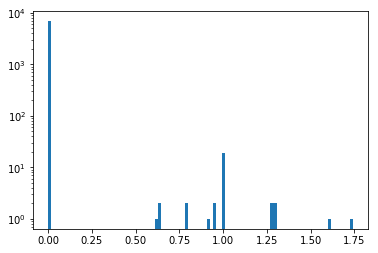

Wall time: 364 ms


In [85]:
%%time
plt.hist(np.abs(eigvals),bins=100,log=True)
plt.show()

In [73]:
np.sum(np.abs(A))

7801